In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3b
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 1e-24
molecule = h2o
ng_adju = [0]
ng_refs = [6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 300
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(0.8, 0.8, 0.8, 0.6, 0.6, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

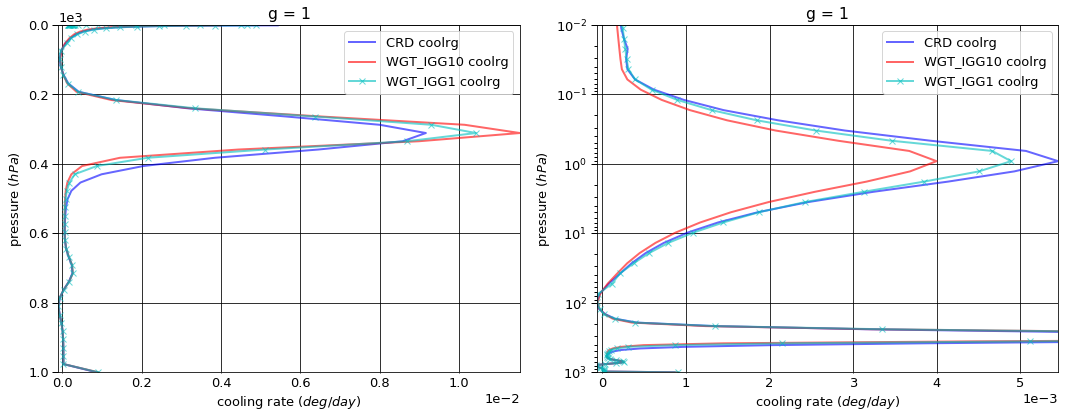

# Figure: cooling rate g-group 2

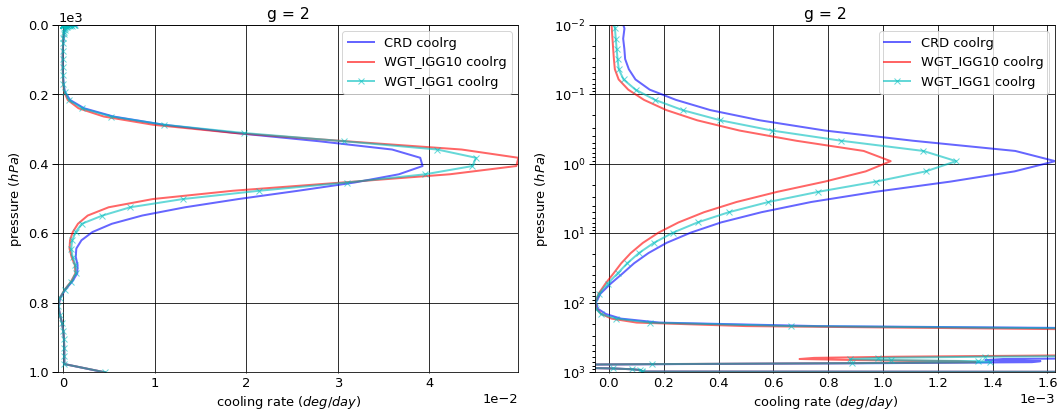

# Figure: cooling rate g-group 3

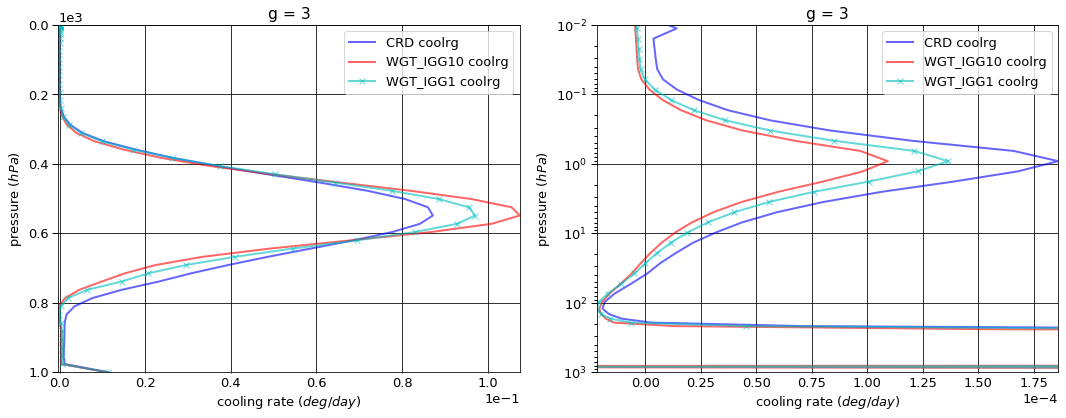

# Figure: cooling rate g-group 4

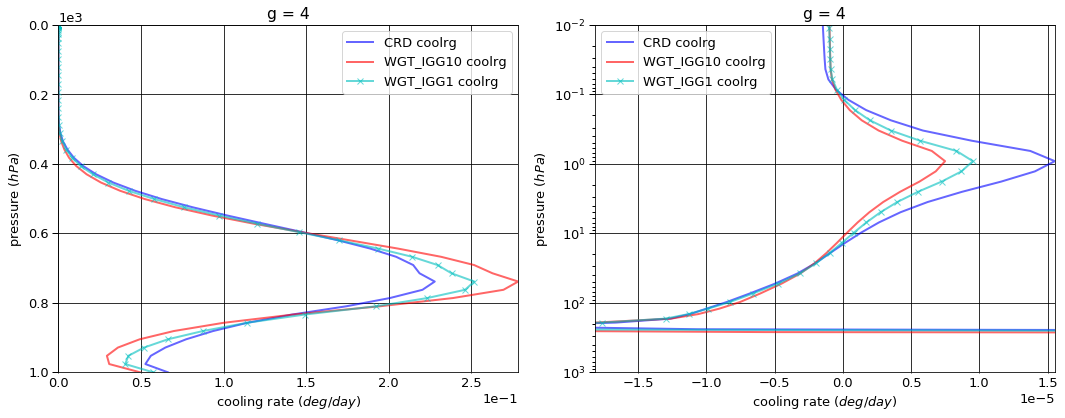

# Figure: cooling rate g-group 5

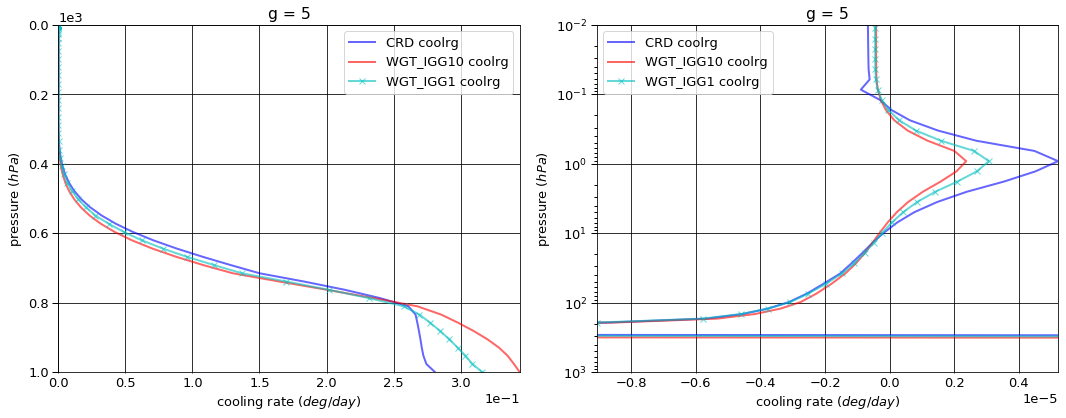

# Figure: cooling rate g-group 6

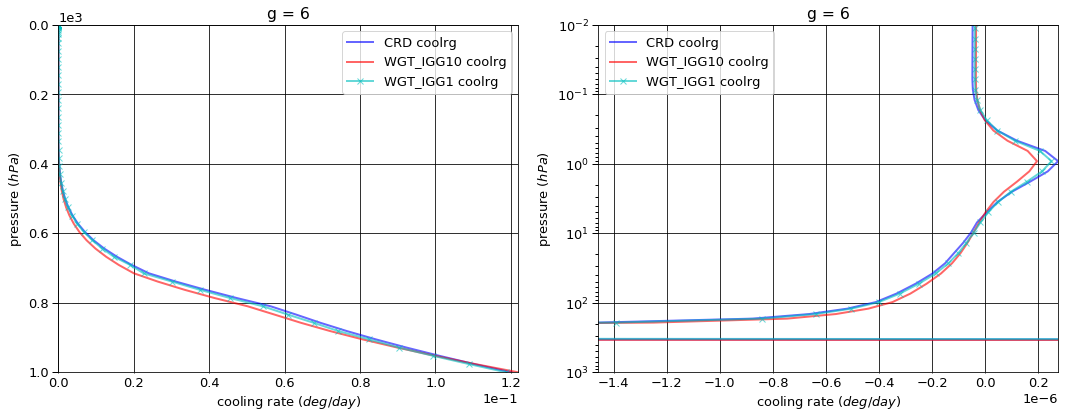

# Figure: cooling rate g-group total

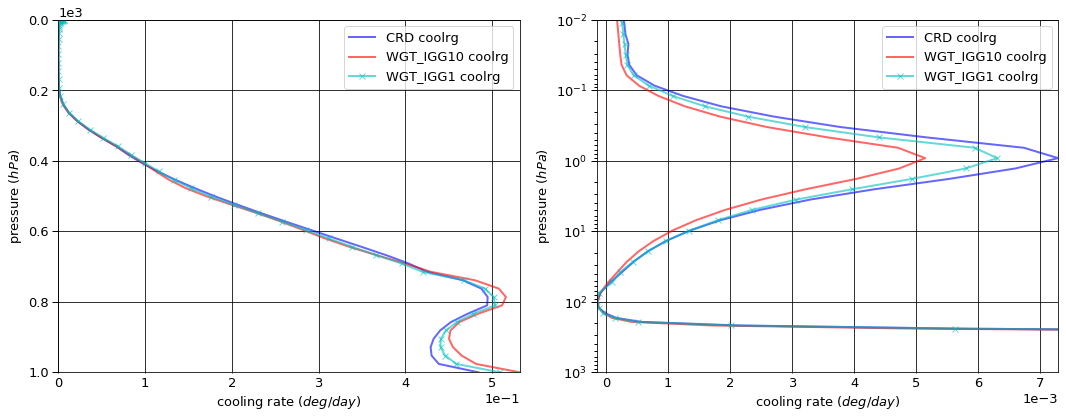

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.154572   0.000000  -0.154572
  1013.0   76     -0.354275   0.351872  -0.002404
2 0.0      1      -0.963656   0.000000  -0.963656
  1013.0   76     -1.818458   1.805879  -0.012579
3 0.0      1      -2.884108   0.000000  -2.884108
  1013.0   76     -4.386204   4.353371  -0.032833
4 0.0      1      -9.210625   0.000000  -9.210625
  1013.0   76    -11.679936  11.314186  -0.365750
5 0.0      1     -16.592591   0.000000 -16.592591
  1013.0   76    -18.304709  12.461869  -5.842840
6 0.0      1     -10.178627   0.000000 -10.178627
  1013.0   76    -10.523967   3.145472  -7.378495


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.149481   0.000000  -0.149481
  1013.0   76     -0.360807   0.358292  -0.002515
2 0.0      1      -0.942099   0.000000  -0.942099
  1013.0   76     -1.828155   1.815410  -0.012745
3 0.0      1      -2.845553   0.000000  -2.845553
  1013.0   76     -4.410593   4.379716  -0.030877
4 0.0      1      -9.207329   0.000000  -9.207329
  1013.0   76    -11.732848  11.539399  -0.193448
5 0.0      1     -16.737584   0.000000 -16.737584
  1013.0   76    -18.361580  12.958905  -5.402675
6 0.0      1     -10.074196   0.000000 -10.074196
  1013.0   76    -10.373566   2.923944  -7.449622


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.149792   0.000000  -0.149792
  1013.0   76     -0.360807   0.358292  -0.002515
2 0.0      1      -0.944546   0.000000  -0.944546
  1013.0   76     -1.828155   1.815410  -0.012745
3 0.0      1      -2.851802   0.000000  -2.851802
  1013.0   76     -4.410593   4.379373  -0.031220
4 0.0      1      -9.214249   0.000000  -9.214249
  1013.0   76    -11.732848  11.500368  -0.232479
5 0.0      1     -16.705824   0.000000 -16.705824
  1013.0   76    -18.361580  12.565885  -5.795694
6 0.0      1     -10.046281   0.000000 -10.046281
  1013.0   76    -10.373566   3.057152  -7.316414


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.005092  0.000000  0.005092
  1013.0   76    -0.006532  0.006420 -0.000112
2 0.0      1      0.021557  0.000000  0.021557
  1013.0   76    -0.009697  0.009531 -0.000166
3 0.0      1      0.038555  0.000000  0.038555
  1013.0   76    -0.024389  0.026345  0.001956
4 0.0      1      0.003297  0.000000  0.003297
  1013.0   76    -0.052912  0.225213  0.172301
5 0.0      1     -0.144993  0.000000 -0.144993
  1013.0   76    -0.056871  0.497036  0.440165
6 0.0      1      0.104431  0.000000  0.104431
  1013.0   76     0.150401 -0.221528 -0.071127


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.004780  0.000000  0.004780
  1013.0   76    -0.006532  0.006420 -0.000112
2 0.0      1      0.019110  0.000000  0.019110
  1013.0   76    -0.009697  0.009531 -0.000166
3 0.0      1      0.032306  0.000000  0.032306
  1013.0   76    -0.024389  0.026003  0.001613
4 0.0      1     -0.003624  0.000000 -0.003624
  1013.0   76    -0.052912  0.186182  0.133270
5 0.0      1     -0.113233  0.000000 -0.113233
  1013.0   76    -0.056871  0.104016  0.047146
6 0.0      1      0.132346  0.000000  0.132346
  1013.0   76     0.150401 -0.088320  0.062082

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.039329e-04
  1001.112500 75     8.628164e-04
2 0.000312    1      1.827295e-05
  1001.112500 75     4.513924e-03
3 0.000312    1     -5.519247e-07
  1001.112500 75     1.148252e-02
4 0.000312    1     -1.723506e-06
  1001.112500 75     6.628815e-02
5 0.000312    1     -6.853773e-07
  1001.112500 75     2.810886e-01
6 0.000312    1     -4.541483e-08
  1001.112500 75     1.201800e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      9.240936e-05
  1001.112500 75     9.024816e-04
2 0.000312    1     -6.271837e-06
  1001.112500 75     4.572737e-03
3 0.000312    1     -6.633279e-06
  1001.112500 75     1.109007e-02
4 0.000312    1     -1.085393e-06
  1001.112500 75     4.944186e-02
5 0.000312    1     -4.171152e-07
  1001.112500 75     3.442238e-01
6 0.000312    1     -3.271021e-08
  1001.112500 75     1.219481e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.366350e-04
  1001.112500 75     9.024816e-04
2 0.000312    1      5.044564e-07
  1001.112500 75     4.572737e-03
3 0.000312    1     -6.383131e-06
  1001.112500 75     1.119991e-02
4 0.000312    1     -1.143801e-06
  1001.112500 75     5.736476e-02
5 0.000312    1     -4.561176e-07
  1001.112500 75     3.163580e-01
6 0.000312    1     -3.703314e-08
  1001.112500 75     1.187874e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.152350e-05
  1001.112500 75     3.966522e-05
2 0.000312    1     -2.454478e-05
  1001.112500 75     5.881290e-05
3 0.000312    1     -6.081354e-06
  1001.112500 75    -3.924490e-04
4 0.000312    1      6.381132e-07
  1001.112500 75    -1.684629e-02
5 0.000312    1      2.682621e-07
  1001.112500 75     6.313525e-02
6 0.000312    1      1.270463e-08
  1001.112500 75     1.768060e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.270218e-05
  1001.112500 75     3.966522e-05
2 0.000312    1     -1.776849e-05
  1001.112500 75     5.881290e-05
3 0.000312    1     -5.831207e-06
  1001.112500 75    -2.826090e-04
4 0.000312    1      5.797055e-07
  1001.112500 75    -8.923384e-03
5 0.000312    1      2.292596e-07
  1001.112500 75     3.526938e-02
6 0.000312    1      8.381690e-09
  1001.112500 75    -1.392650e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-39.984179,0.000000,-39.984179
1013.0,76,-47.067549,33.432649,-13.634901



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-39.956241,0.000000,-39.956241
1013.0,76,-47.067549,33.975666,-13.091883



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-39.912494,0.000000,-39.912494
1013.0,76,-47.067549,33.676481,-13.391068



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.793808e-02,0.000000,0.027938
1013.0,76,1.999999e-08,0.543017,0.543018



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.168494e-02,0.000000,0.071685
1013.0,76,1.999999e-08,0.243832,0.243833


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000119
1001.112500,75,0.484416



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000078
1001.112500,75,0.532179



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000129
1001.112500,75,0.509185



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000041
1001.112500,75,0.047763



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000010
1001.112500,75,0.024769


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00745,0.007666
2,0.03852,0.038841
3,0.09291,0.093708
4,0.24753,0.249277
5,0.38811,0.390111
6,0.22548,0.220397


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.620800e-21
2,2.554449e-22
3,4.025919e-23
4,6.345018e-24
5,1.000002e-24
6,1.306671e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.620800e-21,NaN,0.00745,0.007666,0.00745,0.007666,600.0
2,2.554449e-22,0.157604,0.03852,0.038841,0.04597,0.046507,600.0
3,4.025919e-23,0.157604,0.09291,0.093708,0.13888,0.140215,600.0
4,6.345018e-24,0.157604,0.24753,0.249277,0.38641,0.389491,600.0
5,1.000002e-24,0.157604,0.38811,0.390111,0.77452,0.779603,600.0
6,1.306671e-25,0.130667,0.22548,0.220397,1.00000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
